<a href="https://colab.research.google.com/github/alok-abhishek/User_Review_Analysis_using_App_store_reviews/blob/master/User_Review_Analysis_HeadSpace_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment and Cluster Analysis of Headspace App User Review

**Background and Objective:**

Qualitative research provides in-depth user insights which helps in understanding of reasons, opinions, motivations, and underlying meanings. It helps in unearthing insights which are often missed in qualitative research. However due to nature of data common statistical approach can’t be easily applied to qualitative data and therefore it is time consuming to analyze, and be dependent on interpretation and biases of researchers.

Sentiment Analysis and Clustering techniques makes it a lot easier in analyzing qualitative data and developing insights. By using statistical machine learning techniques we can reduce interpretation biases, and make the analysis more data informed.

Following code downloads 2000 user reviews for Headspace App on Apple App Store and Google Play store. The code uses machine learning to do sentiment analysis on user reviews and creates clusters. The code then does some exploratory data analysis for each of the cluster.

This helps us in identifying common themes across cluster and develop insights which can be used to improve user experience and consequently improve life time value of the users.



In [ ]:
# Let's make sure all the needed packages are installed
! pip install pandas scikit-learn vaderSentiment seaborn matplotlib plotly nltk wordcloud requests app-scraper app-store-scraper google_play_scraper spacy gensim sentence-transformers numpy

In [ ]:
# Let's import packages and libraries

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import os
import nltk
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from google_play_scraper import app, reviews_all, Sort, reviews
from app_store_scraper import AppStore
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from string import punctuation
from collections import Counter
from heapq import nlargest
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
import re

In [ ]:
# Download Apple App Store Review
# App store ID for Headspace: Mindful Meditation on the US App Store
app_store_id = "493145008"
app_store_app = AppStore(country="us", app_name="Headspace", app_id=app_store_id)
# fetching 1000 reviews
app_store_app.review(how_many=1000)

# Create dataframe from reviews
df_app_store = pd.DataFrame(app_store_app.reviews)
df_app_store['Source'] = 'App Store'
df_app_store = df_app_store[['date', 'review', 'rating']]
df_app_store.columns = ['Date', 'Review_Text', 'Rating']
df_app_store['Source'] = 'Apple App Store'
df_app_store['Review_Length'] = df_app_store['Review_Text'].apply(len)

In [ ]:
# describe the data in app store review
print(df_app_store.describe())

            Rating  Review_Length
count  1000.000000    1000.000000
mean      4.467000     765.459000
std       1.088161     208.728517
min       1.000000     446.000000
25%       5.000000     609.000000
50%       5.000000     713.000000
75%       5.000000     884.000000
max       5.000000    1449.000000


In [ ]:
# store Apple App Store review the data in a csv file
df_app_store.to_csv('Headspace_appstore_reviews.csv', index=False)

In [ ]:
# Google Play Store review download
# package name for the app for Headspace: Mindful Meditation on the US Google Play Store
app_id_play_store = "com.getsomeheadspace.android"
# fetching 1000 reviews
count = 1000
result, continuation_token = reviews(
    app_id_play_store,
    count=count,
    lang='en',
    country='us',
    sort=Sort.MOST_RELEVANT
)
df_play_store = pd.DataFrame(result)
df_play_store = df_play_store[['at', 'content', 'score']]
df_play_store.columns = ['Date', 'Review_Text', 'Rating']
df_play_store['Source'] = 'Google Play Store'
df_play_store['Review_Length'] = df_play_store['Review_Text'].apply(len)

In [ ]:
# describe the data in google play store review
print(df_play_store.describe())

            Rating  Review_Length
count  1000.000000    1000.000000
mean      3.111000     362.855000
std       1.522826     150.451859
min       1.000000      42.000000
25%       2.000000     244.500000
50%       3.000000     398.000000
75%       5.000000     482.000000
max       5.000000    1860.000000


In [ ]:
# store google play store review data in a csv file
df_play_store.to_csv('Headspace_playstore_reviews.csv', index=False)

In [ ]:
# Combine both dataframes from apple app store and google play store
df_Headspace_reviews_combined = pd.concat([df_app_store, df_play_store], ignore_index=True)

In [ ]:
# store combined review data from apple app store and google play store in a csv file
df_Headspace_reviews_combined.to_csv('Headspace_AppStore_PlayStore_Combined_reviews.csv', index=False)

If you already have your own cvs file with user interview or review data you can start from this step and export the csv. The code above was to create a data set to explain rest of the process of sentiment analysis and clustering.

In [ ]:
# Load the combined CSV into a data frame
df = pd.read_csv('Headspace_AppStore_PlayStore_Combined_reviews.csv')

In [ ]:
# clean the review data - remove new line and special characters
def clean_text(text):
    # Replace newline characters with space
    text = text.replace('\n', ' ')
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Replace multiple spaces with a single space and strip trailing and leading spaces
    text = ' '.join(text.split()).strip()
    return text

In [ ]:
# Apply the clean_text function to the 'Review_Text' column
df['Review_Text'] = df['Review_Text'].apply(clean_text)

In [ ]:
# Save dataframe to a CSV file to clean the csv
df.to_csv('Headspace_AppStore_PlayStore_Combined_reviews.csv', index=False)

In [ ]:
# Sentiment Analysis using VADER
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Calculate sentiment scores and classify as strongly positive, positive, neutral, negative, or strongly negative
df['Compound'] = df['Review_Text'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['Sentiment'] = df['Compound'].apply(lambda x: 'Strongly positive' if x > 0.6 else ('Positive' if 0.2 <= x <= 0.6 else ('Neutral' if -0.2 <= x <= 0.2 else ('Negative' if -0.6 <= x <= -0.2 else 'Strongly negative'))))


In [ ]:
# Term Frequency-Inverse Document Frequency (TF-IDF) Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3),stop_words='english', max_df=0.85)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Review_Text'].fillna(''))

In [ ]:
# KMeans Clustering
# Create 4 clusters
num_clusters = 4
km = KMeans(n_clusters=num_clusters, random_state=0)
df['Cluster_KMeans_tfidf'] = km.fit_predict(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# t-Distributed Stochastic Neighbor Embedding t-SNE Visualization
tsne = TSNE(n_components=2, random_state=0)
reduced_data = tsne.fit_transform(tfidf_matrix.toarray())
df['X'] = reduced_data[:, 0]
df['Y'] = reduced_data[:, 1]

Cluster analysis in 2D doesnt show clear seperation in between different clusters. A 3D visualization can help here. For my analysis I used wordcloud and more frequent words from each cluster to do the analysis.

In [ ]:
# Visualize Clusters with Plotly
fig_cluster = px.scatter(df, x='X', y='Y', color='Cluster_KMeans_tfidf', hover_data=['Review_Text', 'Rating', 'Sentiment'],
                         color_continuous_scale=px.colors.sequential.Viridis, title='t-SNE Clusters of Reviews')
fig_cluster.show()

In [ ]:
# Visualize Sentiment with Plotly
fig_sentiment = px.scatter(df, x='X', y='Y', color='Sentiment', hover_data=['Review_Text', 'Rating', 'Cluster_KMeans_tfidf'],
                           color_discrete_map={'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'},
                           title='t-SNE Sentiments of Reviews')
fig_sentiment.show()

In [ ]:
# Map the features back to the clusters
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add the cluster column
df_tfidf['Cluster'] = df['Cluster_KMeans_tfidf']

# Group by cluster and get the mean for top terms
cluster_top_terms = df_tfidf.groupby('Cluster').mean()

print(cluster_top_terms)


              000  000 apps  000 apps price       010  010 designer  \
Cluster                                                               
0        0.000388  0.000388        0.000388  0.000000      0.000000   
1        0.000000  0.000000        0.000000  0.000000      0.000000   
2        0.000000  0.000000        0.000000  0.000267      0.000147   
3        0.000000  0.000000        0.000000  0.000000      0.000000   

         010 designer cancelled    030623  030623 fixed  030623 fixed moving  \
Cluster                                                                        
0                      0.000000  0.000000      0.000000             0.000000   
1                      0.000000  0.000000      0.000000             0.000000   
2                      0.000147  0.000155      0.000155             0.000155   
3                      0.000000  0.000000      0.000000             0.000000   

         03302019  ...     zoned  zoned care  zoned care free  zoned craving  \
Cluster     

In [ ]:
# Save the dataframe with added sentiment and cluster columns
df.to_csv('Headspace_AppStore_PlayStore_Combined_reviews_with_sentiments_clusters.csv', index=False)

In [ ]:
# setting up for word cloud
height = 1200
width = 1920
max_words = 500
# Creating stop words to exclude words which dont add value to cluster analysis
stop_words = set(STOPWORDS)
stop_words.update(["app", "Headspace", "headspace","use","ve","just","great", "really", "good"])


In [ ]:
# Extract top 5 topics/terms for each cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Top 5 terms for Cluster {i}:")
    count_terms = 0
    for ind in order_centroids[i, :]:
        if terms[ind] not in stop_words:
            print(f" - {terms[ind]}")
            count_terms += 1
        if count_terms == 5:
            break
    print()

Top 5 terms for Cluster 0:
 - meditation
 - great app
 - dont
 - years
 - helped

Top 5 terms for Cluster 1:
 - meditation
 - life
 - im
 - ive
 - anxiety

Top 5 terms for Cluster 2:
 - free
 - subscription
 - sleep
 - pay
 - meditation

Top 5 terms for Cluster 3:
 - meditations
 - day
 - love
 - meditation
 - helps



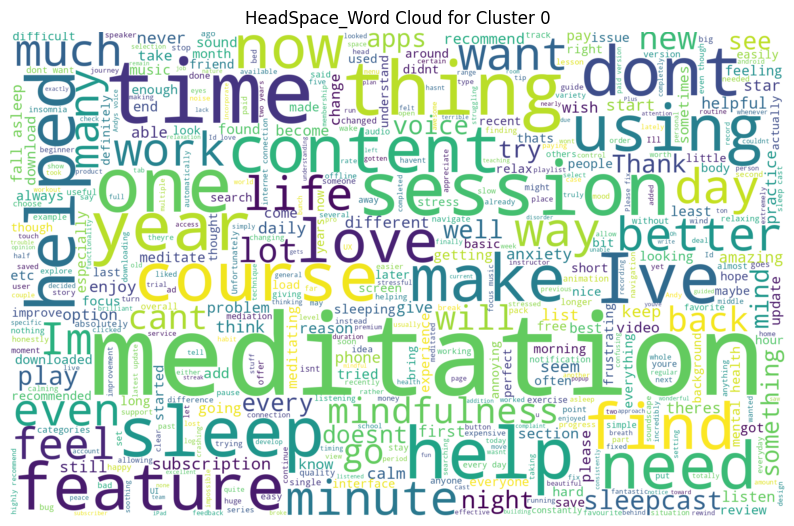

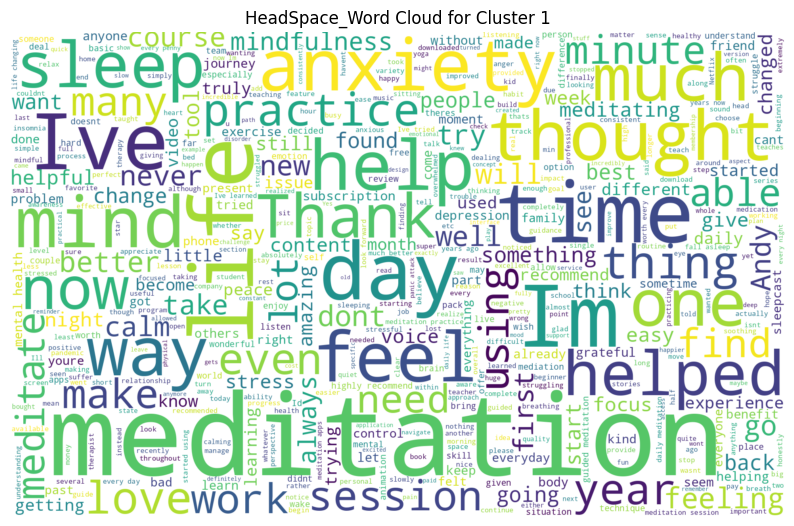

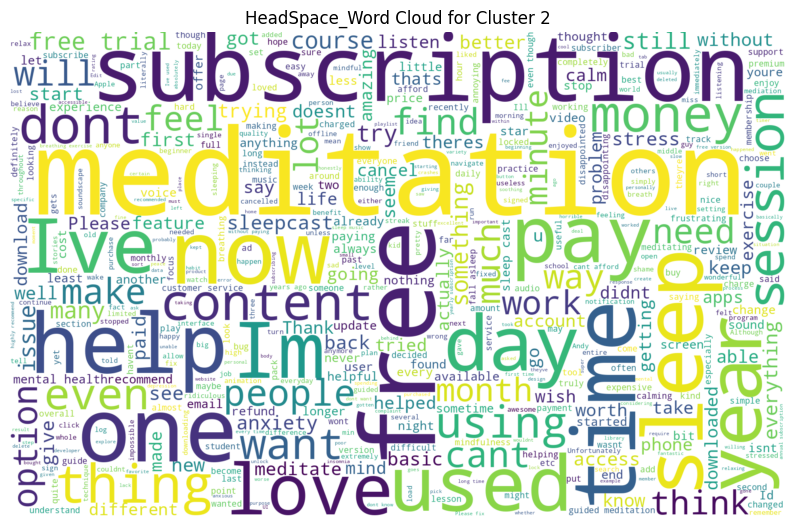

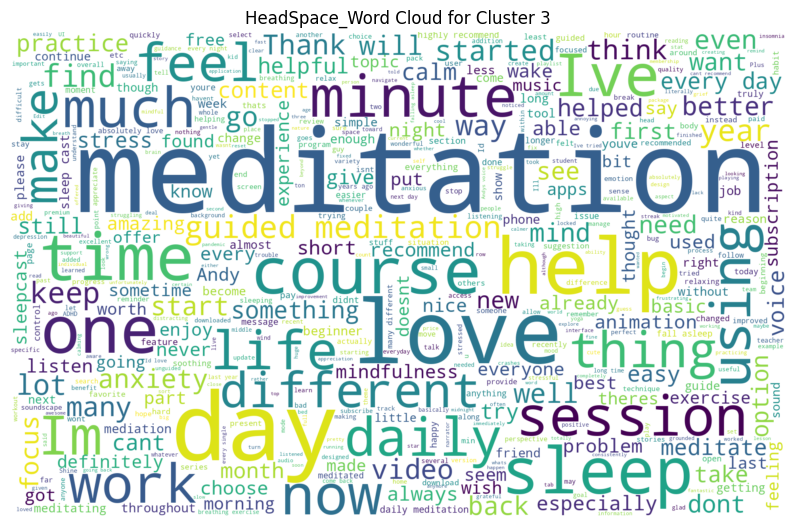

In [ ]:
# Number of unique clusters
num_clusters = df['Cluster_KMeans_tfidf'].nunique()

for cluster_num in range(num_clusters):
    # Extract reviews of the current cluster
    cluster_reviews = df[df['Cluster_KMeans_tfidf'] == cluster_num]['Review_Text'].fillna("").str.cat(sep=' ')

    # Generate word cloud
    wordcloud = WordCloud(width=width,height=height, background_color = 'white', max_words=max_words, stopwords = stop_words).generate(cluster_reviews)

    # Display the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"HeadSpace_Word Cloud for Cluster {cluster_num}")
    plt.show()
    print("\n \n")

    # save it as png file
    wordcloud.to_file(f"HeadSpace_word_cloud_cluster_{cluster_num}.png")



In [ ]:
# Calculate the average rating for each cluster
average_ratings = df.groupby('Cluster_KMeans_tfidf')['Rating'].mean()
print(average_ratings)
average_ratings.to_csv('HeadSapce_AppStore_PlayStore_average_ratings.csv', index=False)

Cluster_KMeans_tfidf
0    3.828000
1    4.655932
2    2.988235
3    4.303226
Name: Rating, dtype: float64


<Figure size 1000x600 with 0 Axes>

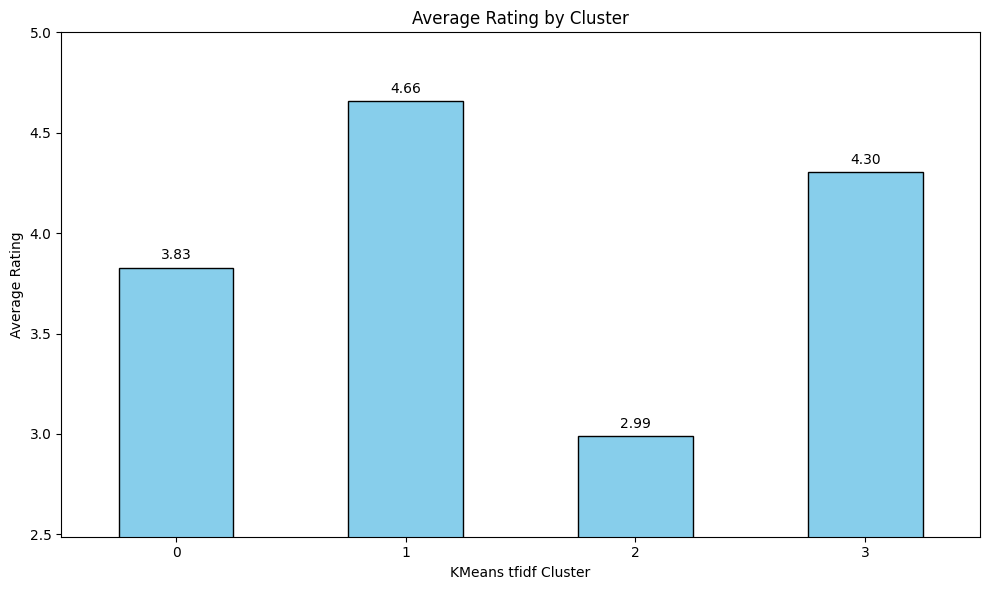

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 6))
average_ratings.plot(kind='bar', color='skyblue', edgecolor='black')

# Title and labels
plt.title('Average Rating by Cluster')
plt.xlabel('KMeans tfidf Cluster')
plt.ylabel('Average Rating')
plt.xticks(rotation=0)
plt.ylim([min(average_ratings) - 0.5, 5])

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.savefig("HeadSpace Average Rating by KMeans tfidf Cluster.png", dpi=300, facecolor='w', edgecolor='b', format='png', transparent=True, bbox_inches='tight')
plt.show()


In [ ]:
# Cross-tabulation tables to do EDA on Cluster, Sentiment, Review and Source
cluster_sentiment = pd.crosstab(df['Cluster_KMeans_tfidf'], df['Sentiment'])
cluster_source = pd.crosstab(df['Cluster_KMeans_tfidf'], df['Source'])
cluster_rating = pd.crosstab(df['Cluster_KMeans_tfidf'], df['Rating'])

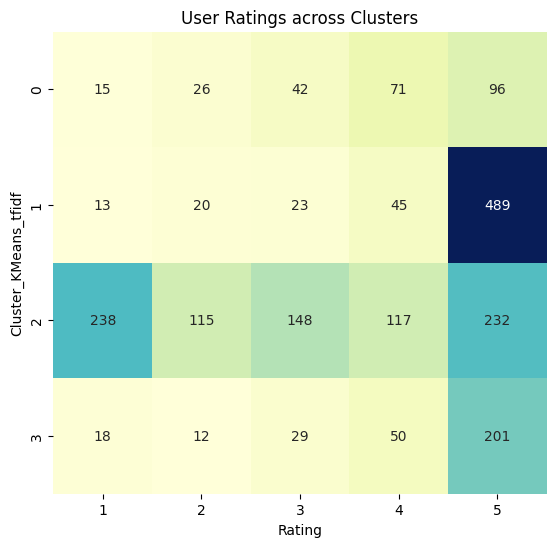

In [ ]:
# Plotting
plt.figure(figsize=(14, 6))

# Plot for Cluster vs Rating
plt.subplot(1, 2, 1)
sns.heatmap(cluster_rating, annot=True, cmap="YlGnBu", fmt='g', cbar=False)

plt.title('User Ratings across Clusters')
plt.savefig("User Rating across Clusters.png", dpi=300, facecolor='w', edgecolor='b', format='png', transparent=True, bbox_inches='tight')


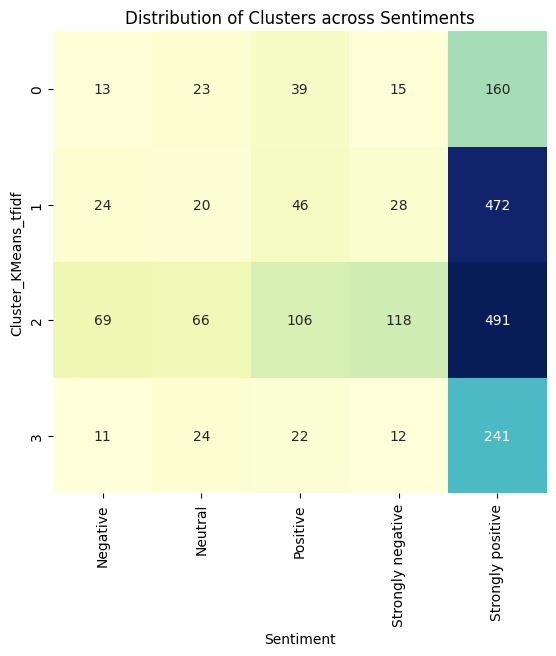

In [ ]:
# Plotting
plt.figure(figsize=(14, 6))

# Plot for Cluster vs Sentiment
plt.subplot(1, 2, 1)
sns.heatmap(cluster_sentiment, annot=True, cmap="YlGnBu", fmt='g', cbar=False)

plt.title('Distribution of Clusters across Sentiments')
plt.savefig("Distribution of Clusters across Sentiments.png", dpi=300, facecolor='w', edgecolor='b', format='png', transparent=True, bbox_inches='tight')



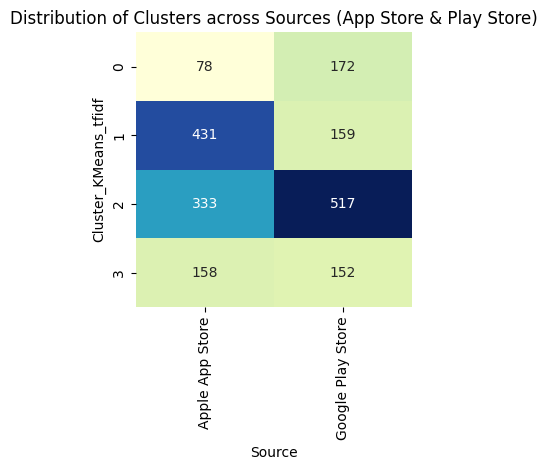

In [ ]:
# Plot for Cluster vs Source
plt.subplot(1, 2, 2)
sns.heatmap(cluster_source, annot=True, cmap="YlGnBu", fmt='g', cbar=False)
plt.title('Distribution of Clusters across Sources (App Store & Play Store)')
plt.tight_layout()
plt.savefig("Distribution of Clusters across Sources.png", dpi=300, facecolor='w', edgecolor='b', format='png', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# Create a pivot table for cluster, sentiment, and source
pivot_table = df.groupby(['Cluster_KMeans_tfidf', 'Sentiment', 'Source']).size().unstack().fillna(0).astype(int)

# Display the pivot table
print(pivot_table)
pivot_table.to_csv('HeadSpace_AppStore_PlayStore_Review_pivot_table.csv', index=False)

Source                                  Apple App Store  Google Play Store
Cluster_KMeans_tfidf Sentiment                                            
0                    Negative                         2                 11
                     Neutral                          1                 22
                     Positive                         6                 33
                     Strongly negative                3                 12
                     Strongly positive               66                 94
1                    Negative                        13                 11
                     Neutral                          7                 13
                     Positive                        20                 26
                     Strongly negative               19                  9
                     Strongly positive              372                100
2                    Negative                        14                 55
                     Neut

In [ ]:

# Cross-tabulation tables
cluster_sentiment = pd.crosstab(df['Cluster_KMeans_tfidf'], df['Sentiment'], margins=True, margins_name="Total")
cluster_source = pd.crosstab(df['Cluster_KMeans_tfidf'], df['Source'], margins=True, margins_name="Total")
sentiment_source = pd.crosstab(df['Sentiment'], df['Source'], margins=True, margins_name="Total")

# Display the tables
print("\nDistribution of Clusters across Sentiments:")
print("------------------------------------------")
print(cluster_sentiment)
print("\n\nDistribution of Clusters across Sources (App Store & Play Store):")
print("--------------------------------------------------------------")
print(cluster_source)
print("\n\nDistribution of Sentiment across Sources (App Store & Play Store):")
print("--------------------------------------------------------------")
print(sentiment_source)


Distribution of Clusters across Sentiments:
------------------------------------------
Sentiment             Negative  Neutral  Positive  Strongly negative  \
Cluster_KMeans_tfidf                                                   
0                           13       23        39                 15   
1                           24       20        46                 28   
2                           69       66       106                118   
3                           11       24        22                 12   
Total                      117      133       213                173   

Sentiment             Strongly positive  Total  
Cluster_KMeans_tfidf                            
0                                   160    250  
1                                   472    590  
2                                   491    850  
3                                   241    310  
Total                              1364   2000  


Distribution of Clusters across Sources (App Store & Play Stor

In [ ]:
# Normalize to get percentages
pivot_table_percentage = (pivot_table / pivot_table.sum().sum() * 100).round(2)

# Display the pivot table with percentages
print(pivot_table_percentage)
pivot_table_percentage.to_csv('HeadSpace_AppStore_PlayStore_pivot_table_percentage.csv', index=False)

Source                                  Apple App Store  Google Play Store
Cluster_KMeans_tfidf Sentiment                                            
0                    Negative                      0.10               0.55
                     Neutral                       0.05               1.10
                     Positive                      0.30               1.65
                     Strongly negative             0.15               0.60
                     Strongly positive             3.30               4.70
1                    Negative                      0.65               0.55
                     Neutral                       0.35               0.65
                     Positive                      1.00               1.30
                     Strongly negative             0.95               0.45
                     Strongly positive            18.60               5.00
2                    Negative                      0.70               2.75
                     Neut

In [ ]:
# Convert counts to percentages
cluster_sentiment_percentage = (cluster_sentiment / df.shape[0] * 100).round(2)

# Display the table with percentages
print(cluster_sentiment_percentage)
cluster_sentiment_percentage.to_csv('HeadSpace_AppStore_PlayStore_cluster_sentiment_percentage.csv', index=False)

Sentiment             Negative  Neutral  Positive  Strongly negative  \
Cluster_KMeans_tfidf                                                   
0                         0.65     1.15      1.95               0.75   
1                         1.20     1.00      2.30               1.40   
2                         3.45     3.30      5.30               5.90   
3                         0.55     1.20      1.10               0.60   
Total                     5.85     6.65     10.65               8.65   

Sentiment             Strongly positive  Total  
Cluster_KMeans_tfidf                            
0                                  8.00   12.5  
1                                 23.60   29.5  
2                                 24.55   42.5  
3                                 12.05   15.5  
Total                             68.20  100.0  


In [ ]:
# Convert counts to percentages
cluster_source_percentage = (cluster_source / df.shape[0] * 100).round(2)

# Display the table with percentages
print(cluster_source_percentage)
cluster_source_percentage.to_csv('HeadSpace_AppStore_PlayStore_cluster_source_percentage.csv', index=False)

Source                Apple App Store  Google Play Store  Total
Cluster_KMeans_tfidf                                           
0                                3.90               8.60   12.5
1                               21.55               7.95   29.5
2                               16.65              25.85   42.5
3                                7.90               7.60   15.5
Total                           50.00              50.00  100.0


In [ ]:
# Calculate the average Review_Length for each cluster
average_Review_Length = df.groupby('Cluster_KMeans_tfidf')['Review_Length'].mean()
average_Review_Length.to_csv('HeadSpace_AppStore_PlayStore_average_Review_Length.csv', index=False)

I was curious if the lenght of review impacts the clustering or not. I was also wondering if there is a correlation in between sentiment, rating, and length of review. It seems like there is not much correlation.

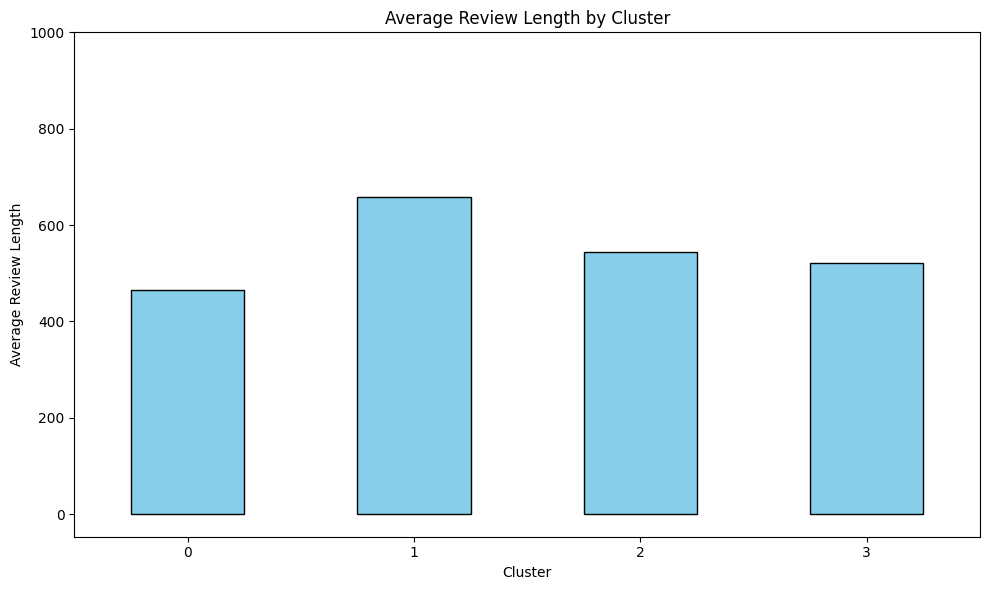

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
average_Review_Length.plot(kind='bar', color='skyblue', edgecolor='black')
# Title and labels
plt.title('Average Review Length by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Review Length')
plt.xticks(rotation=0)
plt.ylim([min(average_ratings) - 50, 1000])
plt.tight_layout()
plt.savefig("HeadSpace Average Review Length by Cluster.png", dpi=300, facecolor='w', edgecolor='b', format='png', transparent=True, bbox_inches='tight')
plt.show()
